# Random Search Algorithms

### Importing Necessary Libraries


In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import numpy as np
import pandas as pd
import seaborn as sns
import mlrose_hiive
import matplotlib.pyplot as plt
np.random.seed(44)
sns.set_style("darkgrid")

### Defining a Fitness Function Object 

In [2]:
# Define alternative N-Queens fitness function for maximization problem
def queens_max(state):
    
    # Initialize counter
    fitness = 0
    
    # For all pairs of queens
    for i in range(len(state) - 1):
        for j in range(i + 1, len(state)):
            
            # Check for horizontal, diagonal-up and diagonal-down attacks
            if (state[j] != state[i]) \
                and (state[j] != state[i] + (j - i)) \
                and (state[j] != state[i] - (j - i)):
                
                # If no attacks, then increment counter
                fitness += 1

    return fitness

# Initialize custom fitness function object
fitness_cust = mlrose.CustomFitness(queens_max)

### Defining an Optimization Problem Object

In [3]:
%%time
# DiscreteOpt() takes integers in range 0 to max_val -1 defined at initialization
number_of_queens = 16
problem = mlrose_hiive.DiscreteOpt(length = number_of_queens, fitness_fn = fitness_cust, maximize = True, max_val = number_of_queens)

CPU times: user 138 µs, sys: 79 µs, total: 217 µs
Wall time: 209 µs


### Optimization #1 Simulated Annealing

In [4]:
%%time
sa = mlrose_hiive.SARunner(problem, experiment_name="SA_Exp", 
                           iteration_list=[10000],
                           temperature_list=[10, 50, 100, 250, 500],
                           decay_list=[mlrose_hiive.ExpDecay,
                                       mlrose_hiive.GeomDecay],
                           seed=44, max_attempts=100)

sa_run_stats, sa_run_curves = sa.run()

CPU times: user 13.6 s, sys: 103 ms, total: 13.7 s
Wall time: 13.6 s


In [5]:
last_iters = sa_run_stats[sa_run_stats.Iteration != 0].reset_index()
print('Mean:', last_iters.Fitness.mean(), '\nMin:',last_iters.Fitness.max(),'\nMax:',last_iters.Fitness.max())
print('Mean Time;',last_iters.Time.mean())

Mean: 118.7 
Min: 119.0 
Max: 119.0
Mean Time; 1.3441894618999999


In [6]:
best_index_in_curve = sa_run_curves.Fitness.idxmax()
best_decay = sa_run_curves.iloc[best_index_in_curve].Temperature
best_curve = sa_run_curves.loc[sa_run_curves.Temperature == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

GeomDecay(init_temp=10, decay=0.99, min_temp=0.001)

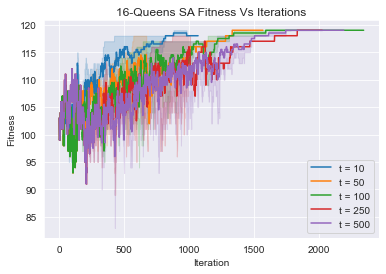

,Iteration,Time,Fitness,FEvals,Temperature,max_iters
0,0,0.000581,103.0,0.0,10.0,10000
1,1,0.004189,100.0,2.0,10.0,10000
2,2,0.004600,99.0,4.0,10.0,10000
3,3,0.005051,99.0,6.0,10.0,10000
4,4,0.005475,100.0,8.0,10.0,10000
...,...,...,...,...,...,...
15663,2187,0.053064,119.0,2871.0,500.0,10000
15664,2188,0.053465,119.0,2872.0,500.0,10000
15665,2189,0.053870,119.0,2873.0,500.0,10000
15666,2190,0.054266,119.0,2874.0,500.0,10000


In [7]:
best_index_in_curve = sa_run_curves.Fitness.idxmax()
best_decay = sa_run_curves.iloc[best_index_in_curve].Temperature
best_sa_curve = sa_run_curves.loc[sa_run_curves.Temperature == best_decay, :]
best_sa_curve.reset_index(inplace=True)


# draw lineplot 
sa_run_curves['Temperature'] = sa_run_curves['Temperature'].astype(str).astype(float)
sa_run_curves_t1 = sa_run_curves[sa_run_curves['Temperature'] == 10] 
sa_run_curves_t2 = sa_run_curves[sa_run_curves['Temperature'] == 50] 
sa_run_curves_t3 = sa_run_curves[sa_run_curves['Temperature'] == 100]
sa_run_curves_t4 = sa_run_curves[sa_run_curves['Temperature'] == 250] 
sa_run_curves_t5 = sa_run_curves[sa_run_curves['Temperature'] == 500] 
sns.lineplot(x="Iteration", y="Fitness", data=sa_run_curves_t1, label = "t = 10")
sns.lineplot(x="Iteration", y="Fitness", data=sa_run_curves_t2, label = "t = 50") 
sns.lineplot(x="Iteration", y="Fitness", data=sa_run_curves_t3, label = "t = 100") 
sns.lineplot(x="Iteration", y="Fitness", data=sa_run_curves_t4, label = "t = 250") 
sns.lineplot(x="Iteration", y="Fitness", data=sa_run_curves_t5, label = "t = 500") 
 
plt.title('16-Queens SA Fitness Vs Iterations')
plt.show()

sa_run_curves

### Optimization #2 Genetic Algorithm

In [8]:
%%time
ga = mlrose_hiive.GARunner(problem=problem,
                          experiment_name="GA_Exp",
                          seed=44,
                          iteration_list = [10000],
                          max_attempts = 100,
                          population_sizes = [100, 500],
                          mutation_rates = [0.1, 0.25, 0.5])

ga_run_stats, ga_run_curves = ga.run()

CPU times: user 1min 10s, sys: 161 ms, total: 1min 10s
Wall time: 1min 11s


In [9]:
last_iters = ga_run_stats[ga_run_stats.Iteration != 0].reset_index()
print("Max and mean")
print(last_iters.Fitness.max(), last_iters.Fitness.mean(), last_iters.Time.mean())
print(last_iters.groupby("Mutation Rate").Fitness.mean())
print(last_iters.groupby("Population Size").Fitness.mean())
print(last_iters.groupby("Population Size").Time.mean())

Max and mean
120.0 118.66666666666667 11.860036887000001
Mutation Rate
0.10    119.5
0.25    118.5
0.50    118.0
Name: Fitness, dtype: float64
Population Size
100    118.000000
500    119.333333
Name: Fitness, dtype: float64
Population Size
100     2.803024
500    20.917050
Name: Time, dtype: float64


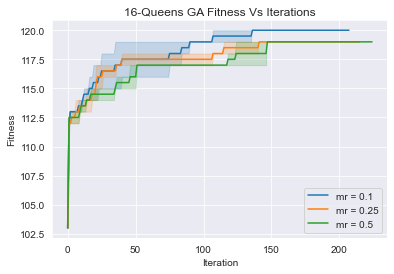

In [10]:
# draw lineplot 
ga_run_curves_mu1 = ga_run_curves[ga_run_curves['Mutation Rate'] == 0.1] 
ga_run_curves_mu2 = ga_run_curves[ga_run_curves['Mutation Rate'] == 0.25] 
ga_run_curves_mu3 = ga_run_curves[ga_run_curves['Mutation Rate'] == 0.5] 
sns.lineplot(x="Iteration", y="Fitness", data=ga_run_curves_mu1, label = "mr = 0.1") 
sns.lineplot(x="Iteration", y="Fitness", data=ga_run_curves_mu2, label = "mr = 0.25") 
sns.lineplot(x="Iteration", y="Fitness", data=ga_run_curves_mu3, label = "mr = 0.5") 
plt.title('16-Queens GA Fitness Vs Iterations')
plt.show()

### Optimization #3 MIMIC

In [11]:
%%time
mmc = mlrose_hiive.MIMICRunner(problem=problem,
                          experiment_name="MMC_Exp",
                          seed=44,
                          iteration_list=[10000],
                          max_attempts=100,
                          population_sizes=[100,500],
                          keep_percent_list=[0.1, 0.25, 0.5],
                          use_fast_mimic=True)

# the two data frames will contain the results
mmc_run_stats, mmc_run_curves = mmc.run()

CPU times: user 56.8 s, sys: 726 ms, total: 57.5 s
Wall time: 57.8 s


In [12]:
last_iters = mmc_run_stats[mmc_run_stats.Iteration != 0].reset_index()
print("Max and mean")
print(last_iters.Fitness.max(), last_iters.Fitness.mean(), last_iters.Time.mean())
print(last_iters.groupby("Keep Percent").Fitness.mean())
print(last_iters.groupby("Population Size").Fitness.mean())
print(last_iters.groupby("Population Size").Time.mean())
mmc_run_curves

Max and mean
119.0 115.33333333333333 9.633991666500004
Keep Percent
0.10    115.0
0.25    116.0
0.50    115.0
Name: Fitness, dtype: float64
Population Size
100    113.666667
500    117.000000
Name: Fitness, dtype: float64
Population Size
100     4.481067
500    14.786917
Name: Time, dtype: float64


,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,Keep Percent,max_iters
0,0,0.022082,103.0,100.0,True,100,0.1,10000
1,1,0.071135,111.0,202.0,True,100,0.1,10000
2,2,0.107040,111.0,303.0,True,100,0.1,10000
3,3,0.158451,111.0,404.0,True,100,0.1,10000
4,4,0.213967,111.0,505.0,True,100,0.1,10000
...,...,...,...,...,...,...,...,...
639,108,0.274129,116.0,54612.0,True,500,0.5,10000
640,109,0.320334,116.0,55113.0,True,500,0.5,10000
641,110,0.368011,116.0,55614.0,True,500,0.5,10000
642,111,0.413872,116.0,56115.0,True,500,0.5,10000


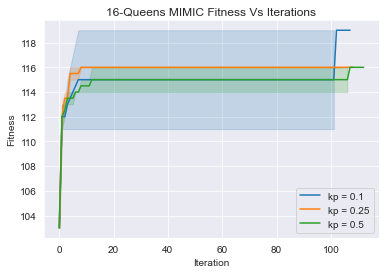

In [13]:
# draw lineplot 
mmc_run_curves_kp1 = mmc_run_curves[mmc_run_curves['Keep Percent'] == 0.1] 
mmc_run_curves_kp2 = mmc_run_curves[mmc_run_curves['Keep Percent'] == 0.25] 
mmc_run_curves_kp3 = mmc_run_curves[mmc_run_curves['Keep Percent'] == 0.5] 
sns.lineplot(x="Iteration", y="Fitness", data=mmc_run_curves_kp1, label = "kp = 0.1") 
sns.lineplot(x="Iteration", y="Fitness", data=mmc_run_curves_kp2, label = "kp = 0.25") 
sns.lineplot(x="Iteration", y="Fitness", data=mmc_run_curves_kp3, label = "kp = 0.5") 
plt.title('16-Queens MIMIC Fitness Vs Iterations')
plt.show()


### Optimization #4 Randomized Hill Climbing


In [14]:
%%time
runner_return = mlrose_hiive.RHCRunner(problem, experiment_name="first_try", 
                                       iteration_list=[10000],
                                       seed=44, max_attempts=100, 
                                       restart_list=[100])
rhc_run_stats, rhc_run_curves = runner_return.run()

CPU times: user 3min 12s, sys: 362 ms, total: 3min 12s
Wall time: 3min 12s


In [15]:
last_iters = rhc_run_stats[rhc_run_stats.Iteration != 0].reset_index()
print(last_iters.Fitness.mean(), last_iters.Fitness.max())
print(last_iters.Time.max())

116.78217821782178 119.0
192.82425359899997


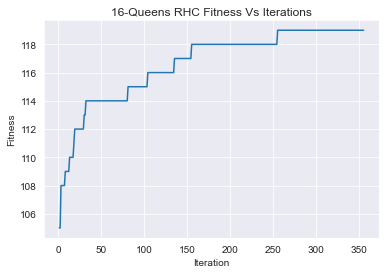

In [16]:
best_index_in_curve = rhc_run_curves.Fitness.idxmax()
best_decay = rhc_run_curves.iloc[best_index_in_curve].current_restart
best_RHC_curve = rhc_run_curves.loc[rhc_run_curves.current_restart == best_decay, :]
best_RHC_curve.reset_index(inplace=True)
best_RHC_curve
# draw lineplot 
sns.lineplot(x="Iteration", y="Fitness", data=best_RHC_curve) 
plt.title('16-Queens RHC Fitness Vs Iterations')
plt.show()

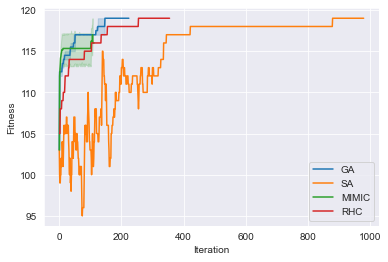

In [17]:
sns.lineplot(x="Iteration", y="Fitness", data=ga_run_curves_mu3, label = "GA") 
sns.lineplot(x="Iteration", y="Fitness", data=best_sa_curve, label = "SA") 
sns.lineplot(x="Iteration", y="Fitness", data=mmc_run_curves, label = "MIMIC") 
sns.lineplot(x="Iteration", y="Fitness", data=best_RHC_curve, label = "RHC") 
plt.show()